In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-11-26 10:34:32.998792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#ARQUIVOS
ATTRIBUTES_FILE = './dataset/attributes.csv'
LABELS_FILE = './dataset/label.csv'

CLASS_NAMES = {
    0: 'Normal',
    1: 'Charge',
    2: 'Discharge',
    3: 'Friction',
    4: 'Charge Discharge',
    5: 'Charge Friction',
    6: 'Discharge Friction',
    7: 'Charge Discharge Friction'
}

nomes_classes = list(CLASS_NAMES.values())


In [3]:
# Configuração para os dados aleatorios se repetirem
np.random.seed(77)
tf.random.set_seed(77)

In [4]:
def carrega_dados(attr_caminho, lbl_caminho):

    print(f"Lendo atributos: {attr_caminho}")
    print(f"Lendo labels: {lbl_caminho}")
    
    X_df = pd.read_csv(attr_caminho)
    y_df = pd.read_csv(lbl_caminho)

    # converte para vetor
    X = X_df.values
    y = y_df.values.flatten() 

    num_classes = len(np.unique(y))
    num_features = X.shape[1]
    
    print(f"Dataset carregado com sucesso:")
    print(f" - Amostras: {X.shape[0]}")
    print(f" - Features (Timestamps): {num_features}")
    print(f" - Classes únicas encontradas: {num_classes} {np.unique(y)}")

    # One-hot para redes neurais
    y_categorical = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    
    return X, y_categorical, y, num_features, num_classes


In [5]:
# MODELOS (Tópico 3.4)

def constroi_mlp(config_name, shape, num_classes):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=shape))
    
    if config_name == '4N':
        model.add(layers.Dense(4, activation='relu'))
    elif config_name == '8N':
        model.add(layers.Dense(8, activation='relu'))
    elif config_name == '16N':
        model.add(layers.Dense(16, activation='relu'))
    elif config_name == '32N':
        model.add(layers.Dense(32, activation='relu'))
    elif config_name == '16-8N':
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(8, activation='relu'))
    elif config_name == '8-8-8N_autoral':
        model.add(layers.Dense(8, activation='relu'))
        model.add(layers.Dense(8, activation='relu'))
        model.add(layers.Dense(8, activation='relu'))
    elif config_name == '32N_autoral':
        model.add(layers.Dense(32, activation='relu'))
    elif config_name == '16N_autoral':
        model.add(layers.Dense(16, activation='sigmoid'))
    elif config_name == 'worst_network':
        model.add(layers.Dense(4, activation='relu'))
        
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


In [6]:
def constroi_cnn(config_name, shape, num_classes):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=shape))
    
    if config_name == 'M1':
        model.add(layers.Conv1D(filters=1, kernel_size=8)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M2':
        model.add(layers.Conv1D(filters=2, kernel_size=8)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M3':
        model.add(layers.Conv1D(filters=1, kernel_size=16)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M4':
        model.add(layers.Conv1D(filters=1, kernel_size=8))
        model.add(layers.AveragePooling1D(pool_size=8))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M5':
        model.add(layers.Conv1D(filters=1, kernel_size=8)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Conv1D(filters=1, kernel_size=8))
        model.add(layers.AveragePooling1D(pool_size=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
     
    elif config_name == 'M6_autoral': #Modelo M1 com tanh
        model.add(layers.Conv1D(filters=1, kernel_size=8)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='tanh'))
        
    elif config_name == 'M7_autoral': #Modelo M2 com tanh
        model.add(layers.Conv1D(filters=2, kernel_size=8))
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='tanh'))
        
    elif config_name == 'M8_autoral': #Modelo M3 com tanh
        model.add(layers.Conv1D(filters=1, kernel_size=16)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='tanh'))
        
    elif config_name == 'M9_autoral': #Modelo M4 com tanh
        model.add(layers.Conv1D(filters=1, kernel_size=8)) 
        model.add(layers.AveragePooling1D(pool_size=8))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='tanh'))
        
    elif config_name == 'M10_autoral': #Modelo M5 com tanh
        model.add(layers.Conv1D(filters=1, kernel_size=8)) 
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Conv1D(filters=1, kernel_size=8))
        model.add(layers.AveragePooling1D(pool_size=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='tanh'))

    elif config_name == 'M11_autoral': #Modelo maior com tanh
        model.add(layers.Conv1D(filters=2, kernel_size=16, padding='same'))
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(32, activation='tanh'))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [7]:
# EXPERIMENTOS
    
X, y_cat, y_integers, n_features, n_classes = carrega_dados(ATTRIBUTES_FILE, LABELS_FILE)

# divisao treino/teste (10% Teste)
X_train, X_test, y_train, y_test, y_train_int, y_test_int = train_test_split(
    X, y_cat, y_integers, test_size=0.10, stratify=y_integers, random_state=24
)

# CNN: (samples, timesteps, features=1)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

mlp_shape = (n_features,)
cnn_shape = (n_features, 1)

EPOCHS = 50 
BATCH_SIZE = 32
K_FOLDS = 10

resultados = []
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=24)

print(f"\nIniciando Validação Cruzada (K={K_FOLDS})...")

Lendo atributos: ./dataset/attributes.csv
Lendo labels: ./dataset/label.csv
Dataset carregado com sucesso:
 - Amostras: 8000
 - Features (Timestamps): 201
 - Classes únicas encontradas: 8 [0 1 2 3 4 5 6 7]

Iniciando Validação Cruzada (K=10)...


In [8]:
# Dicionário para guardar as médias de loss de cada configuração

historico_perdas = {'MLP': {}, 'CNN': {}}

In [9]:
# MLP
configuracoes_mlp = ['16N', '32N_autoral', 'worst_network', '32N', '4N', '8N', '16N_autoral', '16-8N', '8-8-8N_autoral']

for cfg in configuracoes_mlp: 
    print(f"Avaliando MLP: {cfg}")
    tf.keras.backend.clear_session()
    rel_acuracia = []

    loss_train_folds = [] # acumula curvas dos folds de treino
    loss_val_folds = [] # acumula curvas dos folds de validation

    for train_idx, val_idx in skf.split(X_train, y_train_int):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model = constroi_mlp(cfg, mlp_shape, n_classes)

        if(cfg=='32N_autoral'):
            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

            reducao_taxa_aprendizado = ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.2, 
                                                         patience=2, 
                                                         min_lr=1e-7) # patience = nro de epocas que a lr estará ativa

            model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
            history = model.fit(
                X_fold_train, y_fold_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=0,
                validation_data=(X_fold_val, y_fold_val),
                callbacks=[reducao_taxa_aprendizado]
            )
        elif(cfg=='worst_network'):
            opt = tf.keras.optimizers.SGD(learning_rate=0.2)
            #reducao_taxa_aprendizado = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
            model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(
                X_fold_train, y_fold_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=0,
                validation_data=(X_fold_val, y_fold_val)
            )
        else:
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(
                X_fold_train, y_fold_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=0,
                validation_data=(X_fold_val, y_fold_val)
            ) # acrescentado atributo validation_data para guardar cada dado de validação gerado no fit


        loss_train_folds.append(history.history['loss'])
        loss_val_folds.append(history.history['val_loss'])

        historico_perdas['MLP'][cfg] = {
            'train': np.mean(loss_train_folds, axis=0),
            'val': np.mean(loss_val_folds, axis=0)
        } # média das curvas entre os 10 folds para suavizar a curva

        _, acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        rel_acuracia.append(acc)
        
    mean_acc = np.mean(rel_acuracia)
    std_acc = np.std(rel_acuracia)
    resultados.append({'Model': 'MLP', 'Config': cfg, 'Val_Acc_Mean': mean_acc, 'Val_Acc_Std': std_acc})
    print(f"  -> Acurácia Média: {mean_acc:.4f}")
    print(f"  -> Desvio Médio: {std_acc:.4f}")


Avaliando MLP: 16N
  -> Acurácia Média: 0.9978
  -> Desvio Médio: 0.0015
Avaliando MLP: 32N_autoral
  -> Acurácia Média: 0.9990
  -> Desvio Médio: 0.0011
Avaliando MLP: worst_network
  -> Acurácia Média: 0.9915
  -> Desvio Médio: 0.0052
Avaliando MLP: 32N
  -> Acurácia Média: 0.9944
  -> Desvio Médio: 0.0037
Avaliando MLP: 4N
  -> Acurácia Média: 0.9915
  -> Desvio Médio: 0.0029
Avaliando MLP: 8N
  -> Acurácia Média: 0.9956
  -> Desvio Médio: 0.0023
Avaliando MLP: 16N_autoral
  -> Acurácia Média: 0.9974
  -> Desvio Médio: 0.0019
Avaliando MLP: 16-8N
  -> Acurácia Média: 0.9940
  -> Desvio Médio: 0.0081
Avaliando MLP: 8-8-8N_autoral
  -> Acurácia Média: 0.9953
  -> Desvio Médio: 0.0028


In [10]:
# CNN
configuracoes_cnn = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6_autoral', 'M7_autoral', 'M8_autoral', 'M9_autoral', 'M10_autoral', 'M11_autoral']

for cfg in configuracoes_cnn:
    print(f"Avaliando CNN: {cfg}")

    tf.keras.backend.clear_session()

    loss_train_folds = [] # acumula curvas dos folds de treino
    loss_val_folds = [] # acumula curvas dos folds de validation

    rel_acuracia = []

    for train_idx, val_idx in skf.split(X_train, y_train_int):
        X_fold_train, X_fold_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model = constroi_cnn(cfg, cnn_shape, n_classes)

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = model.fit(
            X_fold_train, y_fold_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(X_fold_val, y_fold_val)
        ) # acrescentado atributo validation_data para guardar cada dado de validação gerado no fit

        loss_train_folds.append(history.history['loss'])
        loss_val_folds.append(history.history['val_loss'])

        historico_perdas['CNN'][cfg] = {
            'train': np.mean(loss_train_folds, axis=0),
            'val': np.mean(loss_val_folds, axis=0)
        } # média das curvas entre os 10 folds para suavizar a curva

        _, acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        rel_acuracia.append(acc)
        
    mean_acc = np.mean(rel_acuracia)
    std_acc = np.std(rel_acuracia)
    resultados.append({'Model': 'CNN', 'Config': cfg, 'Val_Acc_Mean': mean_acc, 'Val_Acc_Std': std_acc})
    print(f"  -> Acurácia Média: {mean_acc:.4f}")
    print(f"  -> Desvio Médio: {std_acc:.4f}")


Avaliando CNN: M1
  -> Acurácia Média: 0.9960
  -> Desvio Médio: 0.0021
Avaliando CNN: M2
  -> Acurácia Média: 0.9957
  -> Desvio Médio: 0.0033
Avaliando CNN: M3
  -> Acurácia Média: 0.9969
  -> Desvio Médio: 0.0020
Avaliando CNN: M4
  -> Acurácia Média: 0.9924
  -> Desvio Médio: 0.0023
Avaliando CNN: M5
  -> Acurácia Média: 0.9913
  -> Desvio Médio: 0.0041
Avaliando CNN: M6_autoral
  -> Acurácia Média: 0.9942
  -> Desvio Médio: 0.0034
Avaliando CNN: M7_autoral
  -> Acurácia Média: 0.9958
  -> Desvio Médio: 0.0021
Avaliando CNN: M8_autoral
  -> Acurácia Média: 0.9929
  -> Desvio Médio: 0.0054
Avaliando CNN: M9_autoral
  -> Acurácia Média: 0.9921
  -> Desvio Médio: 0.0037
Avaliando CNN: M10_autoral
  -> Acurácia Média: 0.9944
  -> Desvio Médio: 0.0051
Avaliando CNN: M11_autoral
  -> Acurácia Média: 0.9972
  -> Desvio Médio: 0.0023


In [11]:
# KNN
k_values = [1, 2, 5, 10, 20]
print("\nAvaliando KNN...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    tf.keras.backend.clear_session()
    rel_acuracia = []
    for train_idx, val_idx in skf.split(X_train, y_train_int):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train_labels = y_train_int[train_idx]
        y_fold_val_labels = y_train_int[val_idx]
        knn.fit(X_fold_train, y_fold_train_labels)
        acc = knn.score(X_fold_val, y_fold_val_labels)
        rel_acuracia.append(acc)
    
    mean_acc = np.mean(rel_acuracia)
    std_acc = np.std(rel_acuracia)
    resultados.append({'Model': 'KNN', 'Config': f'K={k}', 'Val_Acc_Mean': mean_acc, 'Val_Acc_Std': std_acc})
    print(f"  -> Acurácia Média: {mean_acc:.4f}")
    print(f"  -> Desvio Médio: {std_acc:.4f}")


Avaliando KNN...
  -> Acurácia Média: 0.8825
  -> Desvio Médio: 0.0137
  -> Acurácia Média: 0.8542
  -> Desvio Médio: 0.0090
  -> Acurácia Média: 0.8899
  -> Desvio Médio: 0.0081
  -> Acurácia Média: 0.8801
  -> Desvio Médio: 0.0101
  -> Acurácia Média: 0.8636
  -> Desvio Médio: 0.0082


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Matriz de Confusão para CNN:
Matriz de Confusão para KNN:
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Matriz de Confusão para MLP:
Modelo Configuracao  Acuracia  Precisao_Macro  Recall_Macro  F1_Macro
   CNN  M11_autoral   0.98875        0.989000       0.98875  0.988741
   KNN          K=5   0.89500        0.896350       0.89500  0.894380
   MLP  32N_autoral   0.99125        0.991403       0.99125  0.991242


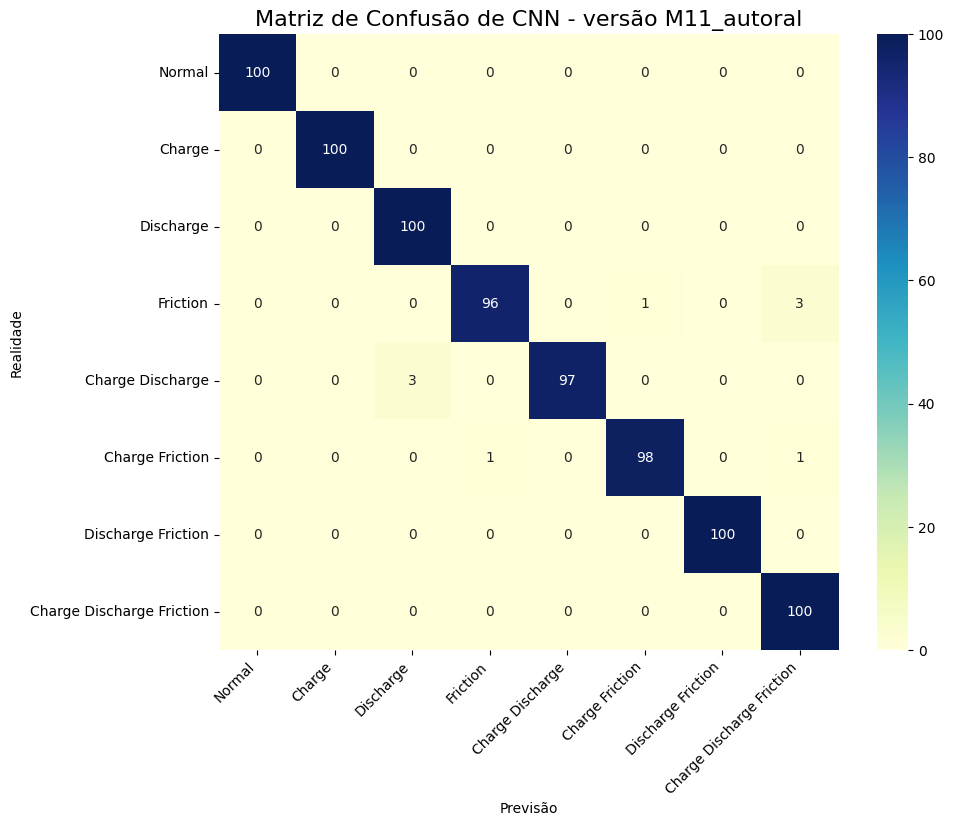

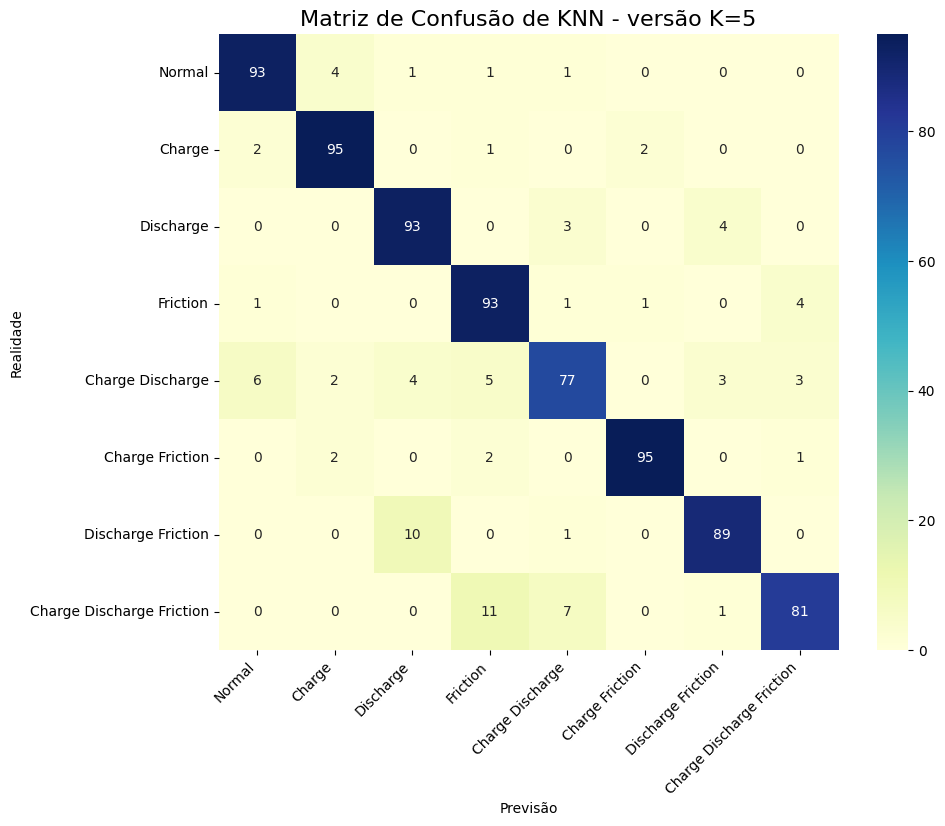

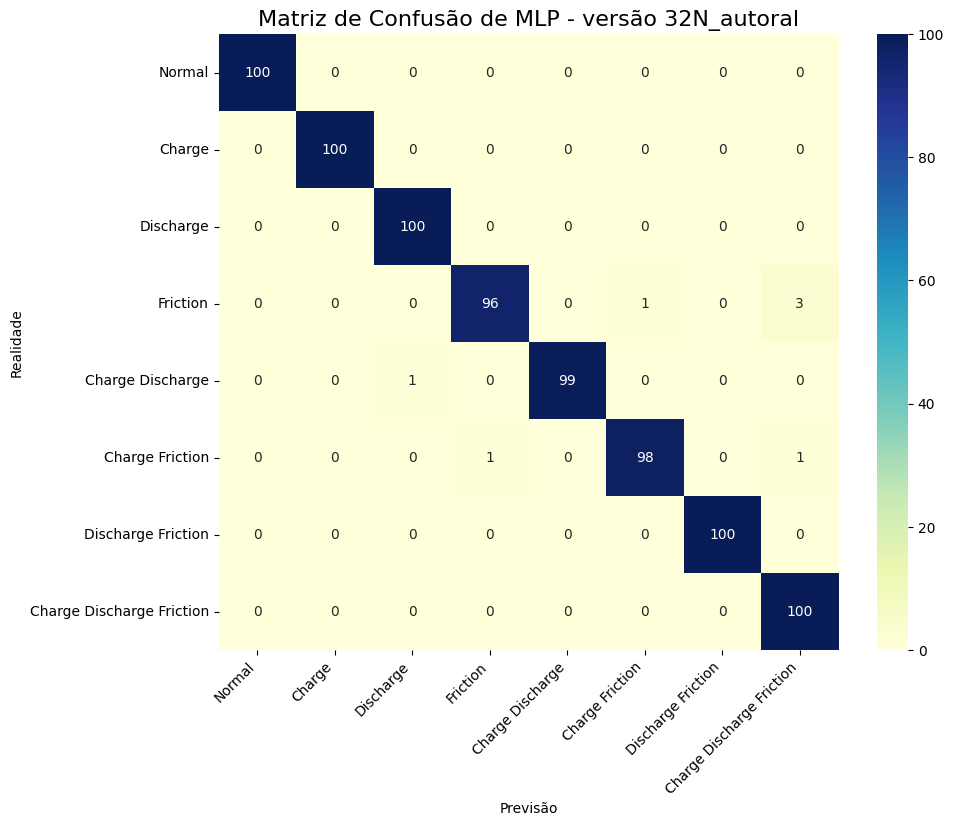

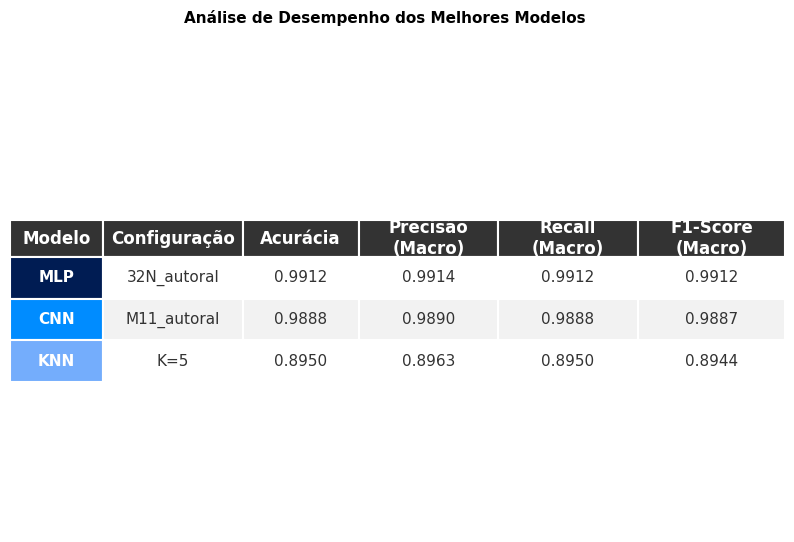

In [21]:
# Resultado Final
resultados_df = pd.DataFrame(resultados)

# Índice de melhor modelo para cada tipo de modelo
idx_melhores = resultados_df.groupby('Model')['Val_Acc_Mean'].idxmax()
melhores_por_tipo = resultados_df.loc[idx_melhores]

matrizes_confusao = {}
metricas_modelos = []

# treinando cada melhor modelo de novo e depois testando com o conjunto de teste
for _, row in melhores_por_tipo.iterrows():
    tipo_modelo = row['Model']
    config = row['Config']
    final_acc = 0

    if tipo_modelo == 'MLP':
        mlp_final = constroi_mlp(config, mlp_shape, n_classes)
        mlp_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        mlp_final.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        loss, final_acc = mlp_final.evaluate(X_test, y_test, verbose=0)
        y_pred_probs = mlp_final.predict(X_test) # saída da CNN, é o vetor de probabilidades gerado pela função softmax
        y_pred = np.argmax(y_pred_probs, axis=1) # pega a maior probabilidade da saída e me retorna a posição dela, ou seja, qual classe o modelo preveu
        y_true = np.argmax(y_test, axis=1) # é a classe verdadeira do dado, retorno a posição de onde está o bit 1, pois está em one hot encoded

    elif tipo_modelo == 'CNN':
        modelo_final = constroi_cnn(config, cnn_shape, n_classes)
        modelo_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        modelo_final.fit(X_train_cnn, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        loss, final_acc = modelo_final.evaluate(X_test_cnn, y_test, verbose=0)
        y_pred_probs = modelo_final.predict(X_test_cnn)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

    elif tipo_modelo == 'KNN':
        k = int(config.split('=')[1])
        modelo_final = KNeighborsClassifier(n_neighbors=k)
        modelo_final.fit(X_train, y_train_int)
        final_acc = modelo_final.score(X_test, y_test_int)
        y_pred = modelo_final.predict(X_test)
        y_true = y_test_int

    # Geração da matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    matrizes_confusao[tipo_modelo] = cm

    # cálculo das medidas da matriz
    n_classes_cm = cm.shape[0]
    precisao_por_classe = []
    recall_por_classe = []
    f1_por_classe = []

    for i in range(n_classes_cm):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precisao = tp / (tp + fp) if (tp + fp) > 0 else 0
        precisao_por_classe.append(precisao)

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recall_por_classe.append(recall)

        f1 = 2 * (precisao * recall) / (precisao + recall) if (precisao + recall) > 0 else 0
        f1_por_classe.append(f1)

    precisao_macro = np.mean(precisao_por_classe)
    recall_macro = np.mean(recall_por_classe)
    f1_macro = np.mean(f1_por_classe)

    acuracia = np.trace(cm) / np.sum(cm)

    metricas_modelos.append({
        'Modelo': tipo_modelo,
        'Configuracao': config,
        'Acuracia': acuracia,
        'Precisao_Macro': precisao_macro,
        'Recall_Macro': recall_macro,
        'F1_Macro': f1_macro
    })

    # plotando matriz de confusão com mapa de calor
    plt.figure(figsize=(10, 8))
    print(f"Matriz de Confusão para {tipo_modelo}:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=nomes_classes, yticklabels=nomes_classes)
    plt.xlabel('Previsão', fontsize=10)
    plt.ylabel('Realidade', fontsize=10)
    plt.title(f'Matriz de Confusão de {tipo_modelo} - versão {config}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    nome_saida = "./images/matriz_confusao_" + tipo_modelo + ".png"
    plt.savefig(nome_saida, dpi=600)
    #plt.show()

# Melhores modelos
df_metricas = pd.DataFrame(metricas_modelos)

print(df_metricas.to_string(index=False))

df_ordenado = df_metricas.sort_values(by='Acuracia', ascending=False)

df_metricas_formatado = df_ordenado.copy()
df_metricas_formatado['Acuracia'] = df_metricas_formatado['Acuracia'].map('{:.4f}'.format)
df_metricas_formatado['Precisao_Macro'] = df_metricas_formatado['Precisao_Macro'].map('{:.4f}'.format)
df_metricas_formatado['Recall_Macro'] = df_metricas_formatado['Recall_Macro'].map('{:.4f}'.format)
df_metricas_formatado['F1_Macro'] = df_metricas_formatado['F1_Macro'].map('{:.4f}'.format)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
ax.axis('tight')

dados_tabela = df_metricas_formatado.values
cabecalhos = ["Modelo", "Configuração", "Acurácia", "Precisão\n(Macro)", "Recall\n(Macro)", "F1-Score\n(Macro)"]

table = ax.table(cellText=dados_tabela,
                 colLabels=cabecalhos,
                 loc='center',
                 cellLoc='center',
                 colWidths=[0.12, 0.18, 0.15, 0.18, 0.18, 0.19])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

CORES = {
    "MLP": "#001C53",
    "CNN": "#008CFF",
    "KNN": "#74ADFC"
}

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('white')
    cell.set_linewidth(1.5)

    if row == 0:
        cell.set_text_props(weight='bold', color='white', size=12)
        cell.set_facecolor('#333333')
        cell.set_height(0.08)
    else:
        idx_real = row - 1
        modelo = df_metricas_formatado.iloc[idx_real]["Modelo"]

        if col == 0:
            cor_fundo = CORES.get(modelo, "#cccccc")
            cell.set_facecolor(cor_fundo)
            cell.set_text_props(weight='bold', color='white')
        else:
            if row % 2 == 0:
                cell.set_facecolor('#f2f2f2')
            else:
                cell.set_facecolor('#ffffff')
            cell.set_text_props(color='#333333')

plt.suptitle('Análise de Desempenho dos Melhores Modelos',
             fontsize=11, fontweight='bold', y=0.98)

nome_saida = "./images/analise_melhores_modelos.png"
plt.savefig(nome_saida, dpi=600, bbox_inches='tight')
plt.show()

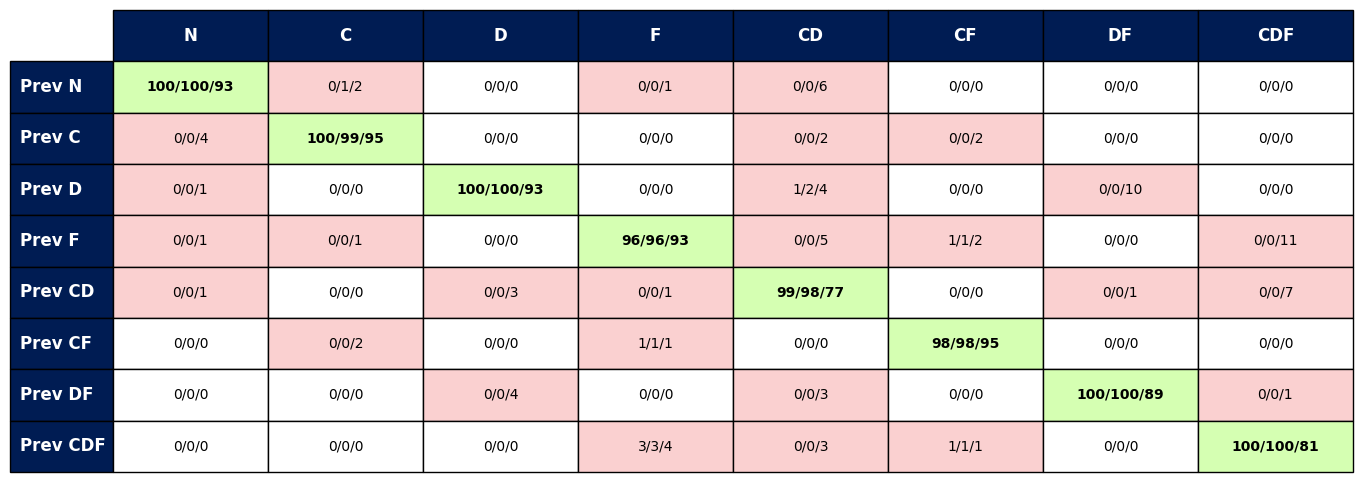

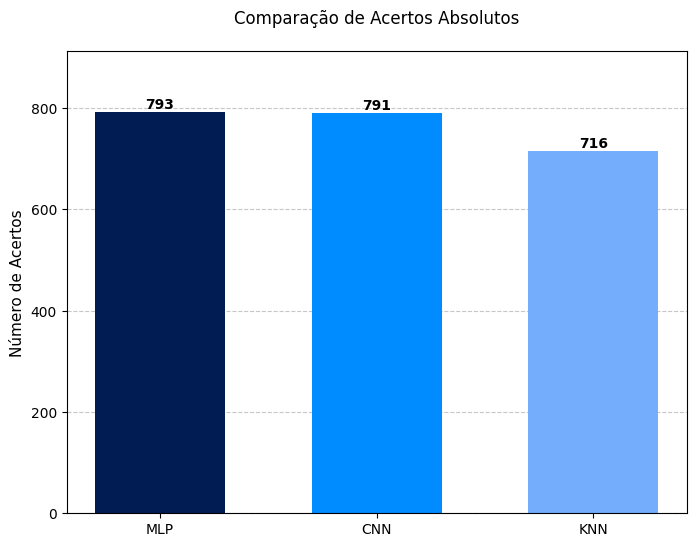

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- CÓDIGO CORRIGIDO ---

# Geração de matriz de confusão combinada + acertos absolutos

if all(k in matrizes_confusao for k in ['MLP', 'CNN', 'KNN']):
    cm_mlp = matrizes_confusao['MLP'].T
    cm_cnn = matrizes_confusao['CNN'].T
    cm_knn = matrizes_confusao['KNN'].T

    acertos_mlp = np.trace(cm_mlp)
    acertos_cnn = np.trace(cm_cnn)
    acertos_knn = np.trace(cm_knn)

    matriz_combinada = np.empty((8, 8), dtype=object)

    for i in range(8):
        for j in range(8):
            matriz_combinada[i, j] = f"{cm_mlp[i,j]}/{cm_cnn[i,j]}/{cm_knn[i,j]}"

    labels_colunas = ['N', 'C', 'D', 'F', 'CD', 'CF', 'DF', 'CDF']
    labels_linhas = [f'Prev {l}' for l in labels_colunas]

    df_combinado = pd.DataFrame(matriz_combinada, index=labels_linhas, columns=labels_colunas)
else:
    print("Falha ao gerar matriz de confusão combinada.")
    acertos_mlp, acertos_cnn, acertos_knn = 0, 0, 0 

# ---------------------------------------------------------
# 1. Tabela da Matriz Combinada
# ---------------------------------------------------------
fig_table, ax_table = plt.subplots(figsize=(16, 6))
ax_table.axis('off')
ax_table.axis('tight')

table = ax_table.table(cellText=df_combinado.values,
                 colLabels=df_combinado.columns,
                 rowLabels=df_combinado.index,
                 loc='center',
                 cellLoc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)

    if row == 0:
        cell.set_facecolor("#001C53")
        cell.set_text_props(weight='bold', color='white', size=12)
    elif col == -1: # Cabeçalho das linhas (índice)
        cell.set_facecolor("#001C53")
        cell.set_text_props(weight='bold', color='white', size=12)
    else:
        # row varia de 1 a 8, col varia de 0 a 7. A diagonal é quando row == col + 1
        if row == col + 1:
            cell.set_facecolor("#d5ffb2") # Verde para acertos
            cell.set_text_props(weight='bold', color='black')
        else:
            texto = cell.get_text().get_text()
            if texto != "0/0/0":
                cell.set_facecolor("#fad0d0") # Vermelho claro para erros
            else:
                cell.set_facecolor('white')

nome_saida_combinada = "./images/matriz_confusao_COMBINADA.png"
# Cria diretório se não existir
import os
os.makedirs("./images", exist_ok=True)
plt.savefig(nome_saida_combinada, dpi=600, bbox_inches='tight')

# ---------------------------------------------------------
# 2. Gráfico de barras para erros absolutos
# ---------------------------------------------------------
fig_bar, ax_bar = plt.subplots(figsize=(8, 6))

modelos = ['MLP', 'CNN', 'KNN']
acertos = [acertos_mlp, acertos_cnn, acertos_knn]
CORES = {
    "MLP": "#001C53",
    "CNN": "#008CFF",
    "KNN": "#74ADFC"
} 

# CORREÇÃO AQUI: Criar uma lista de cores mapeada pela lista de modelos
lista_cores = [CORES[m] for m in modelos]

barras = ax_bar.bar(modelos, acertos, color=lista_cores, width=0.6)

ax_bar.set_title('Comparação de Acertos Absolutos', fontsize=12, pad=20)
ax_bar.set_ylabel('Número de Acertos', fontsize=11)
ax_bar.set_ylim(0, max(acertos) * 1.15) 

for barra in barras:
    height = barra.get_height()
    ax_bar.text(barra.get_x() + barra.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax_bar.yaxis.grid(True, linestyle='--', alpha=0.7)
ax_bar.set_axisbelow(True)

nome_saida_barras = "./images/comparacao_acertos_absolutos.png"
plt.savefig(nome_saida_barras, dpi=600, bbox_inches='tight')

plt.show()

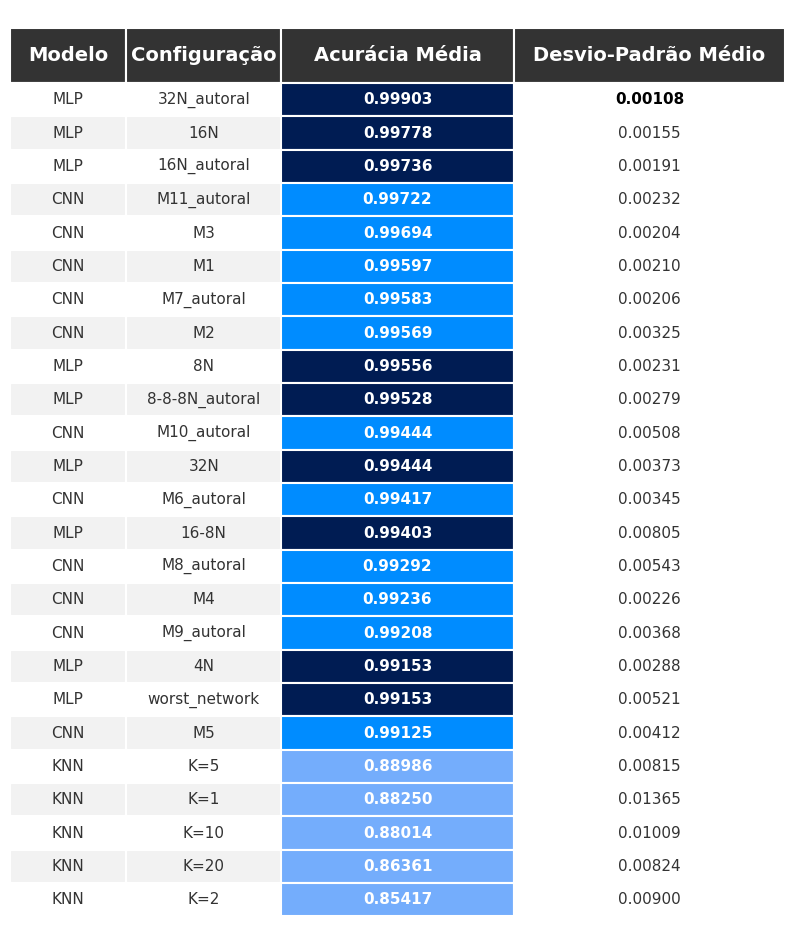

In [20]:
# Geração de tabela para resultados da validação cruzada
#print("\nResumo Completo da Validação Cruzada:")
#print(resultados_df[['Model', 'Config', 'Val_Acc_Mean', 'Val_Acc_Std']].sort_values(by='Val_Acc_Mean', ascending=False))

# preparação dos dados
df = pd.DataFrame({
    "Modelo": resultados_df['Model'],
    "Configuracao": resultados_df['Config'],
    "Media_Acuracia": resultados_df['Val_Acc_Mean'],
    "Media_DP": resultados_df['Val_Acc_Std'],
})
df = df.sort_values(by='Media_Acuracia', ascending=False)
df['Media_Acuracia'] = df['Media_Acuracia'].map('{:.5f}'.format)
df['Media_DP'] = df['Media_DP'].map('{:.5f}'.format)

CORES = {
    "MLP": "#001C53",
    "CNN": "#008CFF",
    "KNN": "#74ADFC"
}
df["Cor"] = df["Modelo"].map(CORES)

# fazendo tabelas
def gerar_tabela(df_filtrado, nome_arquivo, titulo_modelo=""):

    fig, ax = plt.subplots(figsize=(10, 12))
    ax.axis('off')
    ax.axis('tight')

    dados_tabela = df_filtrado[["Modelo", "Configuracao", "Media_Acuracia", "Media_DP"]].values
    melhor_dp = df_filtrado['Media_DP'].min() 
    cabecalhos = ["Modelo", "Configuração", "Acurácia Média", "Desvio-Padrão Médio"]

    table = ax.table(cellText=dados_tabela,
                     colLabels=cabecalhos,
                     loc='center',
                     cellLoc='center',
                     colWidths=[0.15, 0.20, 0.30, 0.35])

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.0)

    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor('white')
        cell.set_linewidth(1.5)

        if row == 0:
            cell.set_text_props(weight='bold', color='white', size=14)
            cell.set_facecolor('#333333')
            cell.set_height(0.06)

        else:
            idx_real = row - 1
            com_id = df_filtrado.iloc[idx_real]["Modelo"]
            valor_dp_real = df_filtrado.iloc[idx_real]["Media_DP"]

            if col == 2:
                cor_fundo = CORES.get(com_id, "#cccccc")
                cell.set_facecolor(cor_fundo)
                cell.set_text_props(weight='bold', color='white')
                        # --- Coluna de Desvio Padrão (Col 3) ---
            elif col == 3:
                # Verifica se é o melhor (menor) DP para negrito
                if valor_dp_real == melhor_dp:
                    cell.set_text_props(weight='bold', color='black', size=11)
                else:
                    cell.set_text_props(weight='normal', color='#333333')

            else:
                if row % 2 == 0:
                    cell.set_facecolor('#f2f2f2')
                else:
                    cell.set_facecolor('#ffffff')
                cell.set_text_props(color='#333333')

    nome_saida = f"./images/{nome_arquivo}"
    plt.savefig(nome_saida, dpi=600, bbox_inches='tight')
    plt.show()

# gerando tabelas
gerar_tabela(df, "tabela_desempenhos_geral.png")


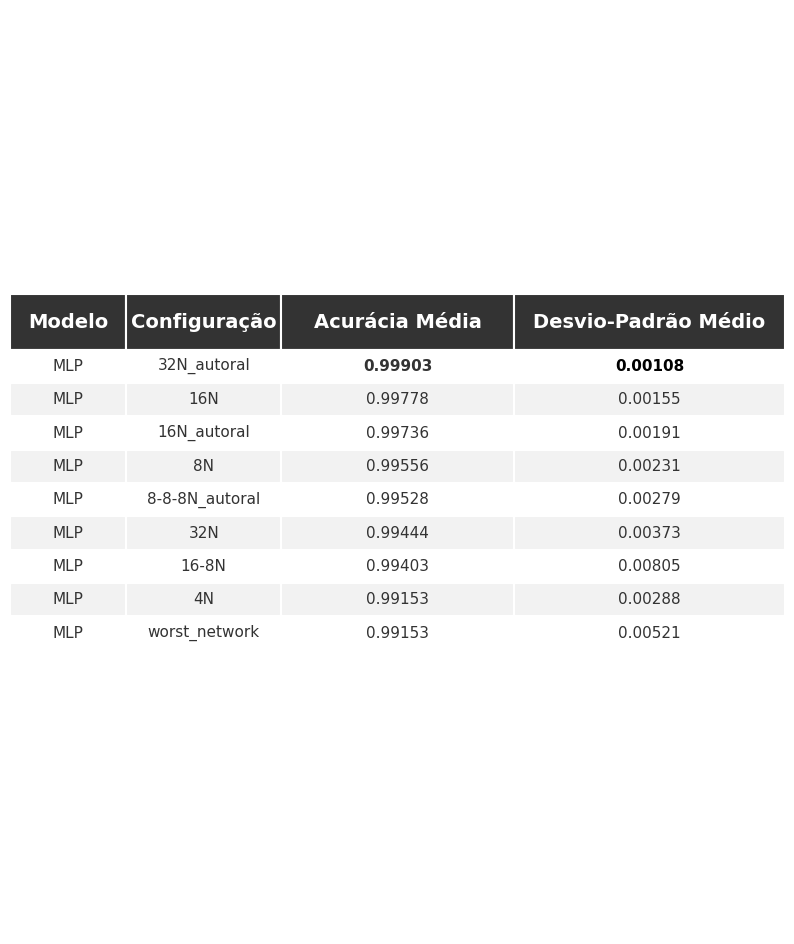

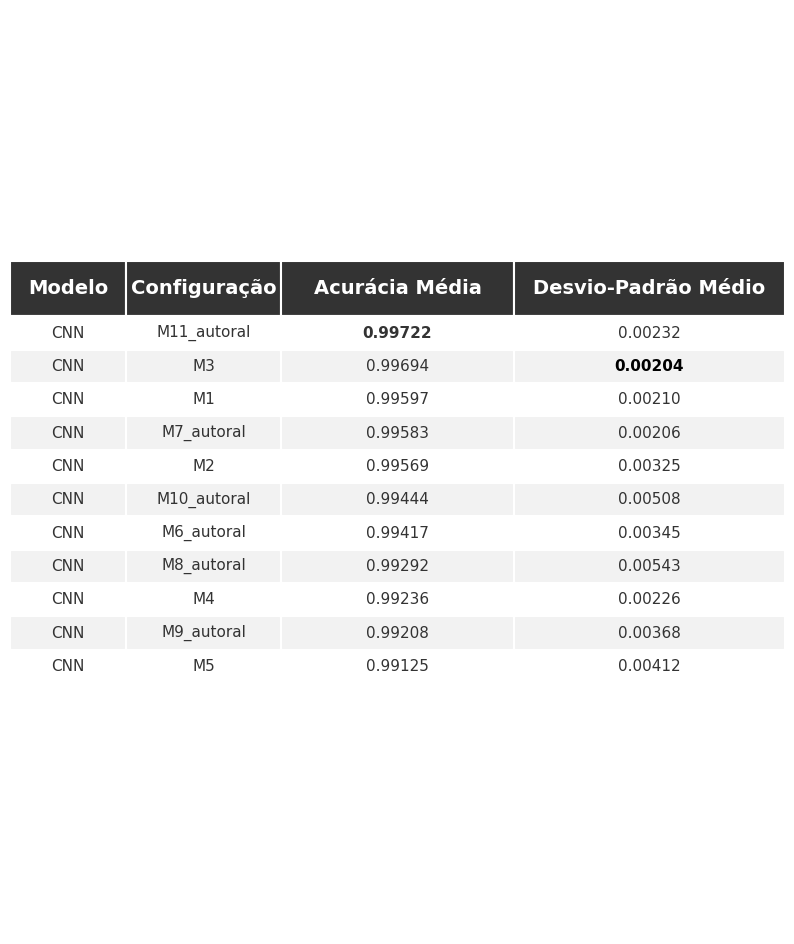

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que resultados_df já exista no seu ambiente
df = pd.DataFrame({
    "Modelo": resultados_df['Model'],
    "Configuracao": resultados_df['Config'],
    "Media_Acuracia": resultados_df['Val_Acc_Mean'], 
    "Media_DP": resultados_df['Val_Acc_Std'],         
})

def gerar_tabela_modelos(df_dados, nome_arquivo):
    
    # Ordena da melhor para a pior acurácia
    df_filtrado = df_dados.sort_values(by='Media_Acuracia', ascending=False).copy()

    # Encontra os melhores valores
    melhor_acc = df_filtrado['Media_Acuracia'].max()
    melhor_dp = df_filtrado['Media_DP'].min() 

    dados_tabela = []
    for i in range(len(df_filtrado)):
        row = df_filtrado.iloc[i]
        dados_tabela.append([
            row["Modelo"],
            row["Configuracao"],
            f"{row['Media_Acuracia']:.5f}", 
            f"{row['Media_DP']:.5f}"        
        ])

    fig, ax = plt.subplots(figsize=(10, 12))
    ax.axis('off')
    ax.axis('tight')

    cabecalhos = ["Modelo", "Configuração", "Acurácia Média", "Desvio-Padrão Médio"]

    table = ax.table(cellText=dados_tabela,
                     colLabels=cabecalhos,
                     loc='center',
                     cellLoc='center',
                     colWidths=[0.15, 0.20, 0.30, 0.35])

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.0)

    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor('white')
        cell.set_linewidth(1.5)

        # --- Cabeçalho ---
        if row == 0:
            cell.set_text_props(weight='bold', color='white', size=14)
            cell.set_facecolor('#333333')
            cell.set_height(0.06)

        # --- Dados ---
        else:
            idx_real = row - 1
            valor_acc_real = df_filtrado.iloc[idx_real]["Media_Acuracia"]
            valor_dp_real = df_filtrado.iloc[idx_real]["Media_DP"]
            
            # Define cor de fundo padrão (zebra: cinza claro / branco)
            if row % 2 == 0:
                cor_fundo = '#f2f2f2'
            else:
                cor_fundo = '#ffffff'
            
            cell.set_facecolor(cor_fundo)

            # --- Coluna de Acurácia (Col 2) ---
            if col == 2:
                # Verifica se é a melhor acurácia para negrito
                if valor_acc_real == melhor_acc:
                    # Texto escuro, pois o fundo agora é claro
                    cell.set_text_props(weight='bold', color='#333333', size=11) 
                else:
                    cell.set_text_props(weight='normal', color='#333333')

            # --- Coluna de Desvio Padrão (Col 3) ---
            elif col == 3:
                # Verifica se é o melhor (menor) DP para negrito
                if valor_dp_real == melhor_dp:
                    cell.set_text_props(weight='bold', color='black', size=11)
                else:
                    cell.set_text_props(weight='normal', color='#333333')

            # --- Outras Colunas (Modelo, Config) ---
            else:
                cell.set_text_props(color='#333333')

    nome_saida = f"./images/{nome_arquivo}"
    
    # Cria a pasta images se não existir
    import os
    os.makedirs("./images", exist_ok=True)

    plt.savefig(nome_saida, dpi=600, bbox_inches='tight')
    plt.show()

# Gerando as tabelas
df_mlp = df[df["Modelo"] == "MLP"].copy()
gerar_tabela_modelos(df_mlp, "tabela_desempenhos_MLP.png")

df_cnn = df[df["Modelo"] == "CNN"].copy()
gerar_tabela_modelos(df_cnn, "tabela_desempenhos_CNN.png")

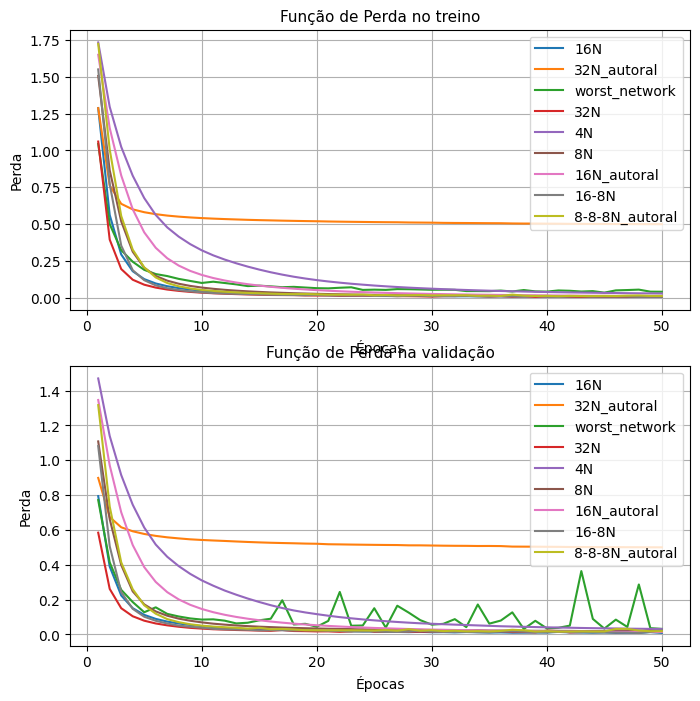

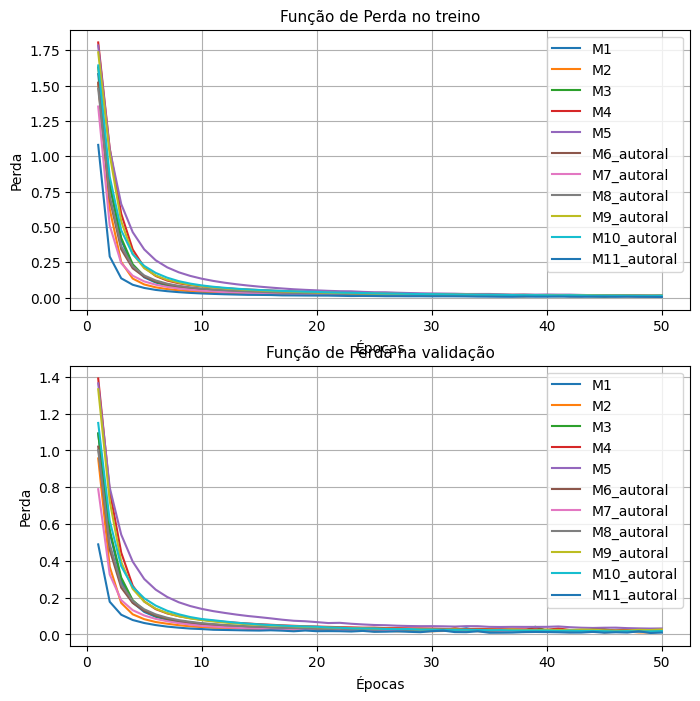

In [17]:
# Gerando gráfico da função de perda a cada época no treinamento das MLP e CNN

def plotar_curvas_loss(historico, tipo_modelo):
    # treino
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    epochs = range(1, EPOCHS + 1)

    for cfg, curvas in historico[tipo_modelo].items():
        ax1.plot(epochs, curvas['train'], label=f'{cfg}')

    ax1.set_title(f'Função de Perda no treino', fontsize=11)
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)

    # validação
    for cfg, curvas in historico[tipo_modelo].items():
        ax2.plot(epochs, curvas['val'], label=f'{cfg}')

    ax2.set_title(f'Função de Perda na validação', fontsize=11)
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Perda')
    ax2.legend()
    ax2.grid(True)

    nome_saida = "./images/grafico_loss_curves" + tipo_modelo + ".png"
    plt.savefig(nome_saida, dpi=600)
    plt.show()

plotar_curvas_loss(historico_perdas, 'MLP')
plotar_curvas_loss(historico_perdas, 'CNN')

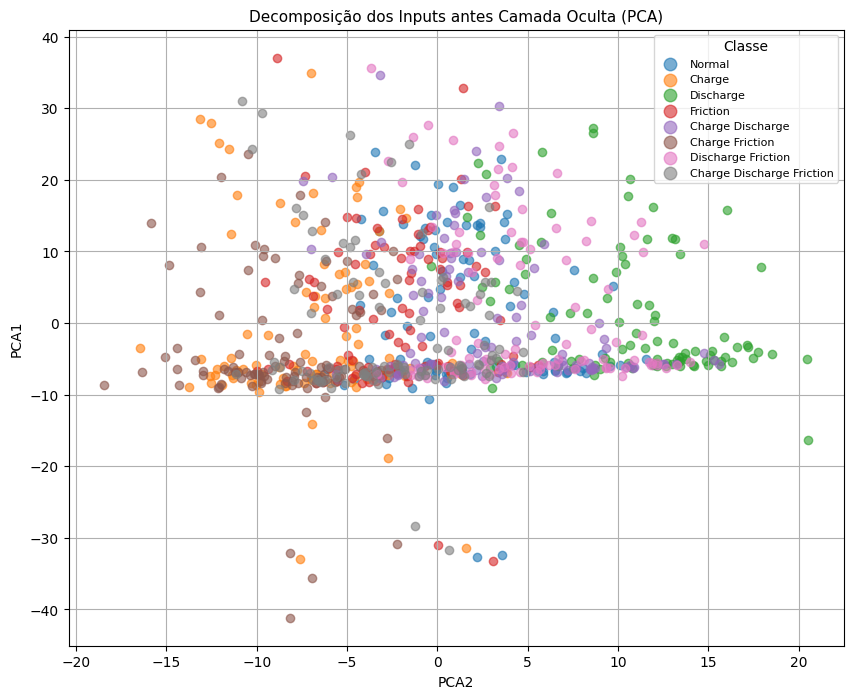

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


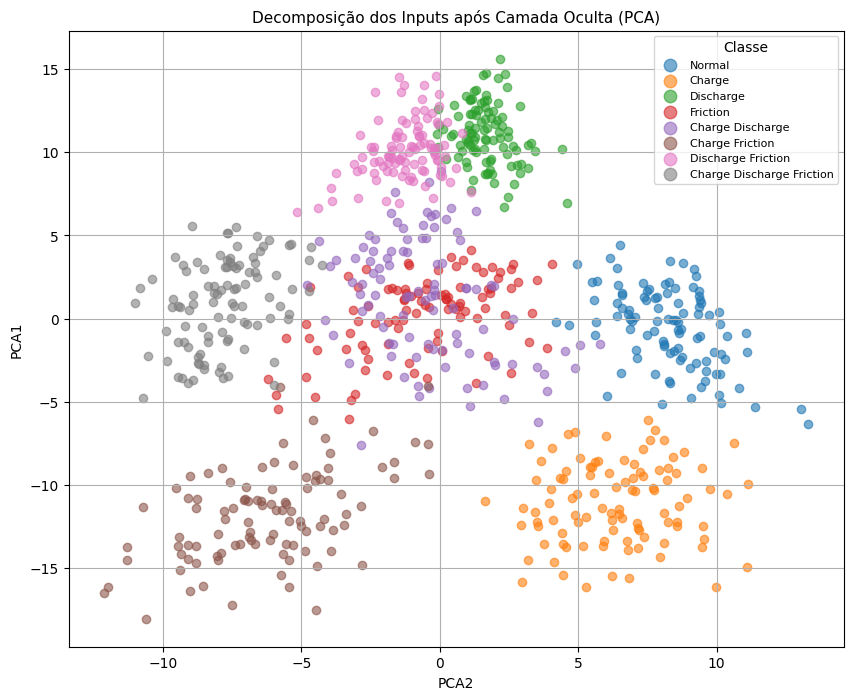

In [18]:
# Geração do PCA para visualização da separação das classes usando o melhor MLP

def gerar_pca(dados, true_labels, titulo, nome_img):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(dados)

    df = pd.DataFrame(data=X_pca, columns=['PCA1','PCA2'])
    df['Classe'] = true_labels

    plt.figure(figsize=(10,8))

    for classe in sorted(df['Classe'].unique()):
        subset = df[df['Classe'] == classe]
        plt.scatter(
            subset['PCA2'],
            subset['PCA1'],
            label=nomes_classes[classe],
            alpha=0.6,
            marker='o'
        )

    plt.xlabel('PCA2', fontsize=10)
    plt.ylabel('PCA1', fontsize=10)
    plt.title(titulo, fontsize=11)
    plt.legend(title='Classe', markerscale=1.5, fontsize=8)
    plt.grid(True)
    nome_saida = "./images/PCA" + nome_img + ".png"
    plt.savefig(nome_saida, dpi=600)
    plt.show()

gerar_pca(dados=X_test, true_labels=y_test_int, titulo='Decomposição dos Inputs antes Camada Oculta (PCA)', nome_img='_pre_camada_oculta')

# Visualizar após a camada oculta nome_img='_pos_camada_oculta'
input_tensor = tf.keras.Input(shape=(n_features,))

x = input_tensor
for layer in mlp_final.layers[:-1]:
    x = layer(x)

saida_oculta = tf.keras.models.Model(
    inputs=input_tensor,
    outputs=x
)

X_saida_oculta = saida_oculta.predict(X_test)

gerar_pca(dados=X_saida_oculta, true_labels=y_test_int, titulo='Decomposição dos Inputs após Camada Oculta (PCA)', nome_img='_pos_camada_oculta')